# Introduction to atomman: Periodic array of dislocations

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook outlines how to construct a periodic array of dislocations, PAD, using the atomman.defect.dislocation_array method. A periodic array of dislocations is an atomic configuration that can investigate the slip motion of a dislocation along a specific slip plane when subjected to applied shear stresses or strains.

__NOTE__: The dislocation_array() function used in this Notebook is to be supplanted by the Dislocation class (added version 1.3.4). This Notebook and the dislocation_array() function are retained for the time being, but may be removed for future versions of atomman. See the [04.9. Dislocation class Jupyter Notebook](04.9._Dislocation_class.html) for the new and improved method.

**Library Imports**

In [1]:
# Standard Python libraries
import os
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.3.5
Notebook executed on 2020-10-06


### 1.1. Theory

A periodic array of dislocations (PAD) represents an infinite array of dislocations with the same Burgers vector, $\vec{b}$, placed on the same slip plane and equally spaced by $l$.  To achieve this using a finite atomic system, a single straight dislocation is inserted into an otherwise bulk crystal, and the system is made periodic along both the dislocation's line direction and the direction the dislocation line moves during slip.  This makes a PAD ideally suited for studying steady state slip of a dislocation in a bulk medium subjected to applied stresses or strains as the dislocation can slip indefinitely across the periodic boundaries.

The dislocation orientation is defined using three orthogonal unit vectors, $\hat{m}$, $\hat{n}$ and $\hat{u}$

- $\hat{u}$ is the dislocation's line direction,
- $\hat{n}$ is the normal to the dislocation's slip plane, and
- $\hat{m}$ is in the slip plane and perpendicular to $\hat{u}$.

For convenience, the dislocation orientation vectors are typically selected to correspond to the Cartesian axes used in defining the atomic system.  Here, we use the Cartesian coordinate system that gives atomic positions, $r$, as

- $\vec{r} = x\hat{u} +y\hat{m} +z\hat{n}$

The alignment of the atomic system's box vectors, $\vec{a}_{box}$, $\vec{b}_{box}$, and $\vec{c}_{box}$, with the dislocation orientation vectors is more complicated as the box vectors need not be orthogonal to each other.  The following rules provide one such alignment that can be adapted to any dislocation

- $\vec{a}_{box}$ is aligned to be parallel to $\hat{u}$.  The system is made periodic along the $\vec{a}_{box}$ direction to simulate an infinitely long straight dislocation,
- $\vec{b}_{box}$ is selected to be perpendicular to $\hat{n}$, and as close to $\hat{m}$ as possible.  This box direction is also made periodic to allow the dislocation to freely move in the $\hat{m}$ direction.  Note that $l = \vec{b} \cdot \hat{m}$, and
- $\vec{c}_{box}$ is then the only one with a component in the $\hat{n}$ direction.  The system is non-periodic in this direction.

Generating a PAD configuration requires inserting the dislocation in such a way that atomic compatibility is retained across the two periodic box boundaries.  There is no issue with compatibility along the $\vec{a}_{box}$ direction if the inserted dislocation is perfectly straight as solutions for straight dislocations are independent of $x$.  Ensuring compatibility along $\vec{b}_{box}$ is more complicated and requires careful consideration of the dislocation solution.

Solutions for straight Volterra dislocations give displacements, $\vec{d}$, to be functions of the radial coordinate, $\theta = \arctan(\frac{y}{x})$, around the dislocation line.  As $\theta$ ranges from $0$ to $2\pi$, $\vec{d}$ increases by $\vec{b}$.  The specific form of the Volterra solutions used by atomman have the following limits for the displacement solution

$$\lim\limits_{y \to \infty} \vec{d}(y, z=0) = 0$$
$$\lim\limits_{y \to -\infty, z \to 0^-} \vec{d}(y, z) = -\vec{b}/2$$
$$\lim\limits_{y \to -\infty,z \to 0^+} \vec{d}(y, z) = \vec{b}/2$$

According to the displacements, the material is perfect crystal infinitely far from the dislocation, but the far-field displacements for $y=\infty$ and $y=-\infty$ limits are shifted by $\pm \frac{\vec{b}}{2}$ relative to each other.

In a finite PAD system, atomic compatibility requires that the full $\vec{b}$ shearing along the slip plane due to the dislocation must take place over the periodic distance $l$ in the $y$ direction.  Thus, a dislocation can be inserted into the center of a PAD by applying a displacement solution that reproduces the limits listed above for $y=y_{min}$ and $y_{max}$ rather than for $y=-\infty$ and $\infty$.  

After displacing the atoms, $\vec{b}_{box}$ can be modified by $\pm \frac{\vec{b}}{2}$ to account for the relative shift at the two periodic $\vec{b}_{box}$ boundaries.  For the screw component of the Burgers vector, $b_{s} = \vec{b} \cdot \hat{u}$, the modification to $\vec{b}_{box}$ is in the $x$ direction and therefore does not affect $l$ or the system's volume.  In contrast, the edge component of the Burgers vector, $b_{e} = \vec{b} \cdot \hat{m}$, will alter $l$ and the system's volume.  Any method for constructing a PAD needs to account for this volume change by appropriately adding or removing atoms.

### 1.2 Methodology overview

The simplest displacement solution that agrees with the rules listed above for creating a PAD system is to apply equal but opposite linear gradients of displacements above and below the slip plane at $z=0$

$$\vec{d}_{lin}(y, z) = \frac{\vec{b}}{2} - \text{sign}(z)\left[ \frac{y\vec{b}}{2l} + \frac{\vec{b}}{4}\right].$$

While this does not give a good approximation of a real dislocation, it does have a couple of benefits besides its simplicity.  First, the solution is independent of the dislocation's position along the slip plane.  This makes it a good choice of displacements for the non-periodic surfaces if the atoms are held rigidly as the interaction between the dislocation and the boundaries will remain constant as the dislocation moves.  Also, since $\vec{d}_{lin}$ depends on $\text{sign}(z)$ rather than $z$ the solution on each side of the slip plane only depends on $y$.

The methodology steps used by the dislocation_array() function method are

1. The function takes as parameters an initially bulk crystalline system and a dislocation solution consisting of $\hat{m}$ $\hat{n}$, and $\vec{b}$.
2. The specified dislocation solution and atomic system are checked for compatibility.  Notably,
   1. $\hat{m}$ and $\hat{n}$ are tested to be orthogonal
   2. $\vec{b} \cdot \hat{n} = 0$ to ensure that $\vec{b}$ is in the slip plane
   3. One box vector must be parallel to $\hat{u} = \hat{m} \times \hat{n}$,
   4. Only one box vector can have a component in the $\hat{n}$ direction.
3. A test system is then constructed by copying the original system and modifying the box vector most aligned with $\hat{m}$ by $\pm \frac{\vec{b}}{2}$. The sign of the modification is taken such that the system's volume always decreases for $\vec{b}$ with edge components.
4. The atoms in the test system are then displaced using $\vec{d}_{lin}$.  
5. The excess duplicate atoms due to the box modification are searched for and identified by finding all atoms within a very small radial distance from each other.  The number of identified duplicate atoms is verified to match the expected number to remove based on the system's volume decrease.
6. The PAD system is then created based on the modified box boundaries and original atomic positions for all non-duplicate atoms.
7. The atoms in the PAD system are then displaced according to any supplied dislocation solution.
   1. If no dislocation solution is given (only $\hat{m}$ $\hat{n}$, and $\vec{b}$), then all atoms are displaced using $\vec{d}_{lin}$.
   2. If a dislocation solution is given, such as a Volterra solution, that solution is used for all atoms in the system except at the free surfaces parallel to the slip plane.  The boundary atoms at the free surfaces are displaced according to $\vec{d}_{lin}$.
   
*Added old_id atom property version 1.3.2*

Most of the dislocation analysis tools in atomman require comparing the defect system to a compatible defect-free system. For the periodic array of dislocations systems constructed here, the initial system can be used as long as the deleted atoms for dislocations with edge components are accounted for. The atoms in the new dislocation system can be mapped directly back to the reference system by using the old_id atomic property that is now assigned by the function.

### 1.3. dislocation_array() docstring

Method that converts a bulk crystal system into a periodic array of dislocations.  A single dislocation is inserted using a dislocation solution.  The system's box and pbc are altered such that the system is periodic and compatible across the two box vectors contained in the slip plane.  The third box vector is non-periodic, resulting in free surfaces parallel to the dislocation's slip plane.
    
Parameters

- __system__ (*atomman.System*) A perfect, bulk atomic system.

- __dislsol__ (*atomman.defect.Stroh or atomman.defect.IsotropicVolterra, optional*) A dislocation solution to use to displace atoms by.  If not given, all atoms will be given linear displacements associated with the long-range limits.

- __m__ (*array-like object, optional*) The dislocation solution m unit vector.  This vector is in the slip plane and perpendicular to the dislocation line direction.  Only needed if dislsol is not given.

- __n__ (*array-like object, optional*) The dislocation solution n unit vector.  This vector is normal to the slip plane.  Only needed if dislsol is not given.

- __burgers__ (*array-like object, optional*) The Cartesian Burger's vector for the dislocation relative to the given system's Cartesian coordinates.  Only needed if dislsol is not given.

- __bwidth__ (*float, optional*) The width of the boundary region at the free surfaces.  Atoms within the boundaries will be displaced by linear displacements instead of by the dislocation solution.  Only given if dislsol is not None.  Default value if dislsol is given is 10 Angstroms.

- __cutoff__ (*float, optional*) Cutoff distance to use for identifying duplicate atoms to remove.  For dislocations with an edge component, applying the displacements creates an extra half-plane of atoms that will have (nearly) identical positions with other atoms after altering the boundary conditions.  Default cutoff value is 0.5 Angstrom.

Returns

(*atomman.System*) The system with the dislocation displacements added.

## 2. Only linear displacements

This is the simplest variation of the method, and is best used for planar screw dislocations and split dislocations with large stacking fault widths.

### 2.1. Define bulk system and dislocation

Define an fcc unit cell

In [2]:
# 0K ucell for fcc Al using the 2008--Mendelev-M-I--Al potential.
a = uc.set_in_units(4.0453, 'angstrom')
symbols = ['Al']
box = am.Box.cubic(a)
atoms = am.Atoms(pos=[[0.0, 0.0, 0.0],
                      [0.5, 0.5, 0.0],
                      [0.5, 0.0, 0.5],
                      [0.0, 0.5, 0.5]])
ucell = am.System(atoms=atoms, box=box, symbols=symbols, scale=True)

Dislocation parameters for an fcc $\frac{a}{2}<10\bar{1}>\{111\}$ dislocation

In [3]:
# Edge component direction (m) parallel to y-axis
m = [0, 1, 0]

# Slip plane normal (n) parallel to z-axis
n = [0, 0, 1]

# Miller Burgers vector
burgers_uvw = 0.5 * np.array([1, 0, -1])

# Miller slip plane
slip_hkl = np.array([1, 1, 1])

# The dislocation's line direction (ξ_uvw) determines character
#ξ_uvw = [ 1,-2, 1] # 90 degree edge
ξ_uvw = [1, -1, 0] # 60 degree mixed
#ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw

# Half-plane shift to avoid atoms exactly on slip plane
atomshift = [0.0, 0.0, a * 3 ** 0.5 / 6]

Identify rotation uvws to use

In [4]:
uvws = am.defect.dislocation_system_basis(ξ_uvw, slip_hkl, m=m, n=n, box=box)
print(uvws)

[[ 1. -1.  0.]
 [ 1.  1. -2.]
 [ 1.  1.  1.]]


Rotate system and shift atoms

In [5]:
rcell, transform = ucell.rotate(uvws, return_transform=True)

rcell.atoms.pos += np.asarray(atomshift)

Transform burgers_uvw to a Cartesian vector relative to the rotated system

In [6]:
# Transform to Cartesian
burgers = am.tools.miller.vector_crystal_to_cartesian(burgers_uvw, ucell.box)

# Transform to rotated system
burgers = transform.dot(burgers)
print(f'b = [{burgers[0]:7.5f}, {burgers[1]:7.5f}, {burgers[2]:7.5f}] Angstroms')
print(f'|b| = {np.linalg.norm(burgers)} Angstroms')

b = [1.43023, 2.47723, 0.00000] Angstroms
|b| = 2.860459061933942 Angstroms


Increase system size, especially along m direction. Keep m and n directions centered at (0,0)

In [7]:
system = rcell.supersize(3, (-30, 30), (-10, 10))
print(system.natoms, 'atoms')

86400 atoms


### 2.2 Apply linear displacements

Generate the dislocation system by applying only linear displacements. If the Burgers vector has edge components, the number of atoms will be less than in the initial system.

In [8]:
dislsystem = am.defect.dislocation_array(system, m=m, n=n, burgers=burgers)
print(dislsystem.natoms, 'atoms')

86220 atoms


Show that box has been changed

In [9]:
print('initial box')
print(system.box)
print()

print('dislocation box')
print(dislsystem.box)

initial box
avect =  [17.163,  0.000,  0.000]
bvect =  [ 0.000, 594.535,  0.000]
cvect =  [ 0.000,  0.000, 140.133]
origin = [ 0.000, -297.268, -70.067]

dislocation box
avect =  [17.163,  0.000,  0.000]
bvect =  [-0.715, 593.297,  0.000]
cvect =  [ 0.000,  0.000, 140.133]
origin = [ 0.000, -297.268, -70.067]


Plot atomic displacements. Note that the reference system is the atoms in the original system that are still in the dislsystem.

In [10]:
refsystem = system.atoms_ix[dislsystem.atoms.old_id]

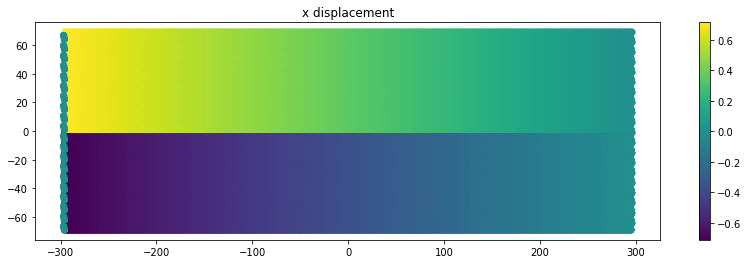

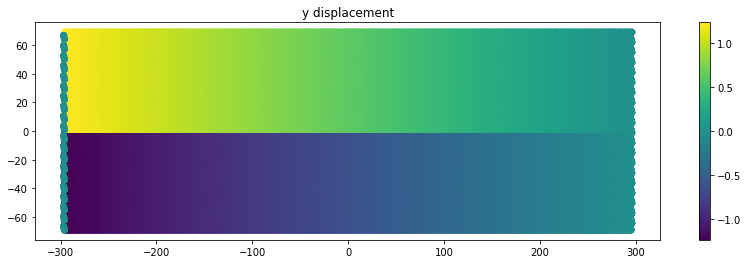

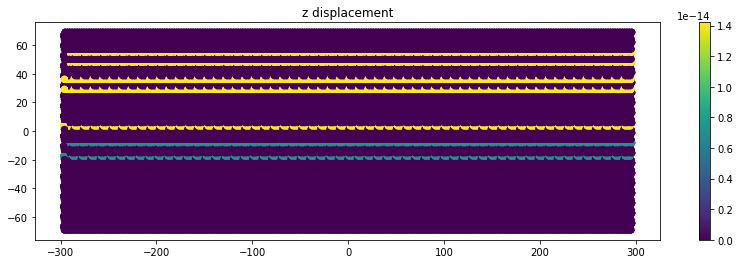

In [11]:
x = dislsystem.atoms.pos.dot(m)
y = dislsystem.atoms.pos.dot(n)
fig = plt.figure(figsize=(14,4))
plt.scatter(x, y, c=am.displacement(refsystem, dislsystem)[:,0])
plt.title('x displacement')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(14,4))
plt.scatter(x, y, c=am.displacement(refsystem, dislsystem)[:,1])
plt.title('y displacement')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(14,4))
plt.scatter(x, y, c=am.displacement(refsystem, dislsystem)[:,2])
plt.title('z displacement')
plt.colorbar()
plt.show()

## 3. Volterra dislocation 

For dislocations with compact cores, it may be preferable to construct the core using a Volterra solution.

### 3.1 Define bulk system and dislocation

Use the same bulk system and dislocation definition as above

Specify elastic constants

In [12]:
# 0K Cij for fcc Al using the 2008--Mendelev-M-I--Al potential.
C11 = uc.set_in_units(105.09, 'GPa')
C12 = uc.set_in_units( 59.46, 'GPa')
C44 = uc.set_in_units( 30.66, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)
print('Cij in GPa:')
print(uc.get_in_units(C.Cij, 'GPa'))

Cij in GPa:
[[105.09  59.46  59.46   0.     0.     0.  ]
 [ 59.46 105.09  59.46   0.     0.     0.  ]
 [ 59.46  59.46 105.09   0.     0.     0.  ]
 [  0.     0.     0.    30.66   0.     0.  ]
 [  0.     0.     0.     0.    30.66   0.  ]
 [  0.     0.     0.     0.     0.    30.66]]


In [13]:
# Get dislocation solution using solve_volterra
dislsol = am.defect.solve_volterra_dislocation(C, burgers_uvw, ξ_uvw=ξ_uvw, slip_hkl=slip_hkl, box=box, m=m, n=n)

K_tensor = dislsol.K_tensor
print('K_tensor in GPa:')
print(uc.get_in_units(K_tensor, 'GPa'))

K_tensor in GPa:
[[26.44821166  0.          0.        ]
 [ 0.         41.22064506  0.70363751]
 [ 0.          0.70363751 41.71819191]]


In [14]:
dislsystem = am.defect.dislocation_array(system, dislsol=dislsol)
print(dislsystem.natoms, 'atoms')

86220 atoms


Plot atomic displacements

In [15]:
refsystem = system.atoms_ix[dislsystem.atoms.old_id]

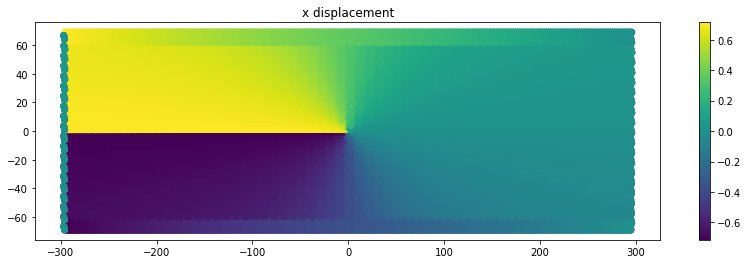

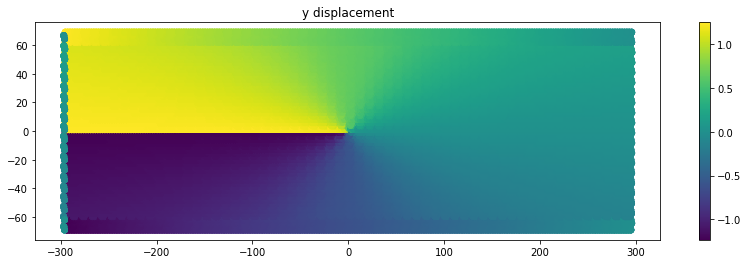

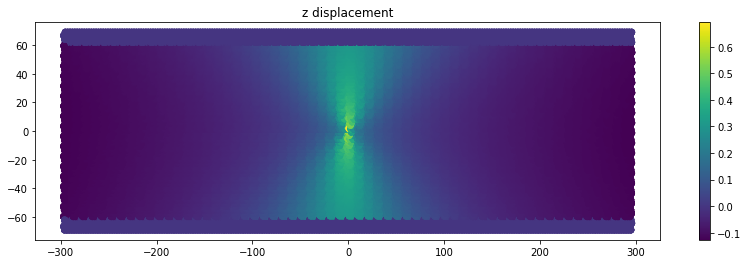

In [16]:
x = dislsystem.atoms.pos.dot(m)
y = dislsystem.atoms.pos.dot(n)
fig = plt.figure(figsize=(14,4))
plt.scatter(x, y, c=am.displacement(refsystem, dislsystem)[:,0])
plt.title('x displacement')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(14,4))
plt.scatter(x, y, c=am.displacement(refsystem, dislsystem)[:,1])
plt.title('y displacement')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(14,4))
plt.scatter(x, y, c=am.displacement(refsystem, dislsystem)[:,2])
plt.title('z displacement')
plt.colorbar()
plt.show()

## 4. Dislocation analysis

Most of the dislocation analysis tools built into atomman rely on a reference system.  The same reference system as used for the displacements above can be used with those tools.

NOTE: The core structures plotted are not relaxed and therefore are horrible! This is just an example of how to use the analysis tools on properly relaxed systems.

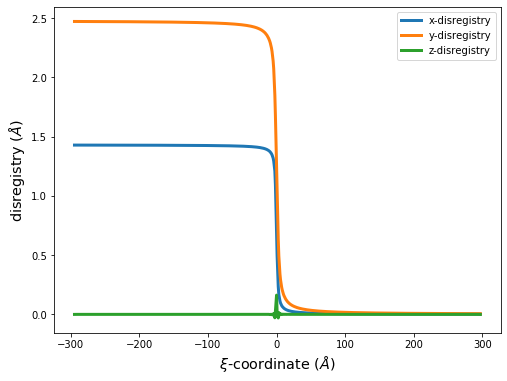

In [17]:
xi, disreg = am.defect.disregistry(refsystem, dislsystem, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

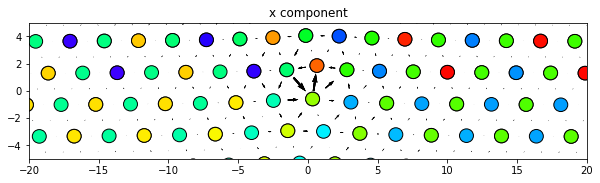

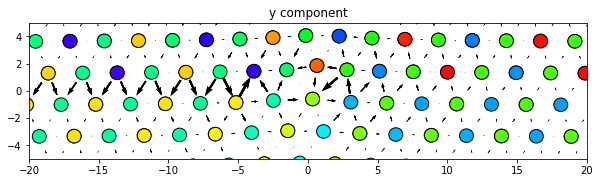

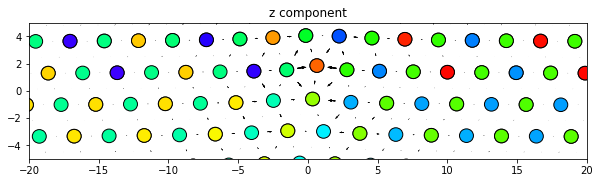

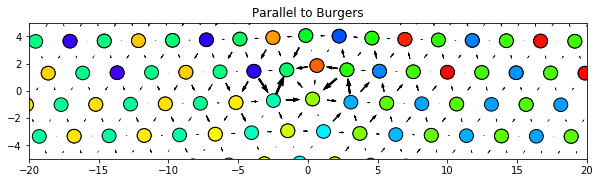

In [18]:
dd = am.defect.DifferentialDisplacement(refsystem, dislsystem, cutoff = 0.9*a)

ddmax = np.linalg.norm(burgers) / 4   # a/2<110> fcc dislocations use |b|/4

# Set dict of keyword parameter values (just to make settings same for all plots below)
params = {}
params['plotxaxis'] = 'y'
params['plotyaxis'] = 'z'
params['xlim'] = (-20, 20)
params['ylim'] = (-5, 5)
params['zlim'] = (-0.01, a*6**0.5 / 2 + 0.01) # Should be one periodic width (plus a small cushion)
params['figsize'] = 10         # Only one value as the other is chosen to make plots "regular"
params['arrowwidth'] = 1/50    # Made bigger to make arrows easier to see
params['arrowscale'] = 2.4     # Typically chosen to make arrows of length ddmax touch the corresponding atom circles

dd.plot('x', ddmax, **params)
plt.title('x component')
plt.show()

dd.plot('y', ddmax, **params)
plt.title('y component')
plt.show()

dd.plot('z', ddmax, **params)
plt.title('z component')
plt.show()

dd.plot(burgers, ddmax, **params)
plt.title('Parallel to Burgers')
plt.show()